### **Load & Filter Data for TCS and Reliance**

In [43]:
import pandas as pd

# Load dataset
df = pd.read_csv('TCS.csv')

# Filter for TCS only
tcs_data = df[df['Symbol'] == 'TCS'].copy()

# Convert 'Date' to datetime and sort
tcs_data['Date'] = pd.to_datetime(tcs_data['Date'])
tcs_data.sort_values('Date', inplace=True)
tcs_data.reset_index(drop=True, inplace=True)

# Calculate moving averages
tcs_data['MA20'] = tcs_data['Close'].rolling(window=20).mean()
tcs_data['MA50'] = tcs_data['Close'].rolling(window=50).mean()

# Drop rows with NaN values caused by moving averages
tcs_data = tcs_data.dropna().reset_index(drop=True)

print(tcs_data.head())

        Date Symbol Series  Prev Close    Open     High      Low    Last  \
0 2011-06-01    TCS     EQ     1157.15  1157.0  1177.00  1157.00  1174.7   
1 2011-06-02    TCS     EQ     1175.40  1158.9  1172.00  1156.65  1170.0   
2 2011-06-03    TCS     EQ     1167.75  1166.0  1175.00  1150.00  1153.0   
3 2011-06-06    TCS     EQ     1152.10  1140.0  1168.00  1140.00  1167.0   
4 2011-06-07    TCS     EQ     1164.35  1163.0  1183.15  1158.00  1180.0   

     Close     VWAP  Volume      Turnover   Trades  Deliverable Volume  \
0  1175.40  1171.25  491193  5.753106e+13  24427.0              235463   
1  1167.75  1163.45  848827  9.875700e+13  31879.0              505320   
2  1152.10  1157.15  683904  7.913794e+13  21179.0              416548   
3  1164.35  1156.70  678537  7.848626e+13  20965.0              373937   
4  1179.30  1175.19  918721  1.079673e+14  26487.0              598039   

   %Deliverble       MA20      MA50  
0       0.4794  1144.8025  1155.683  
1       0.5953  1147.4

###**Plot Closing Prices & Volumes for Both Stocks**

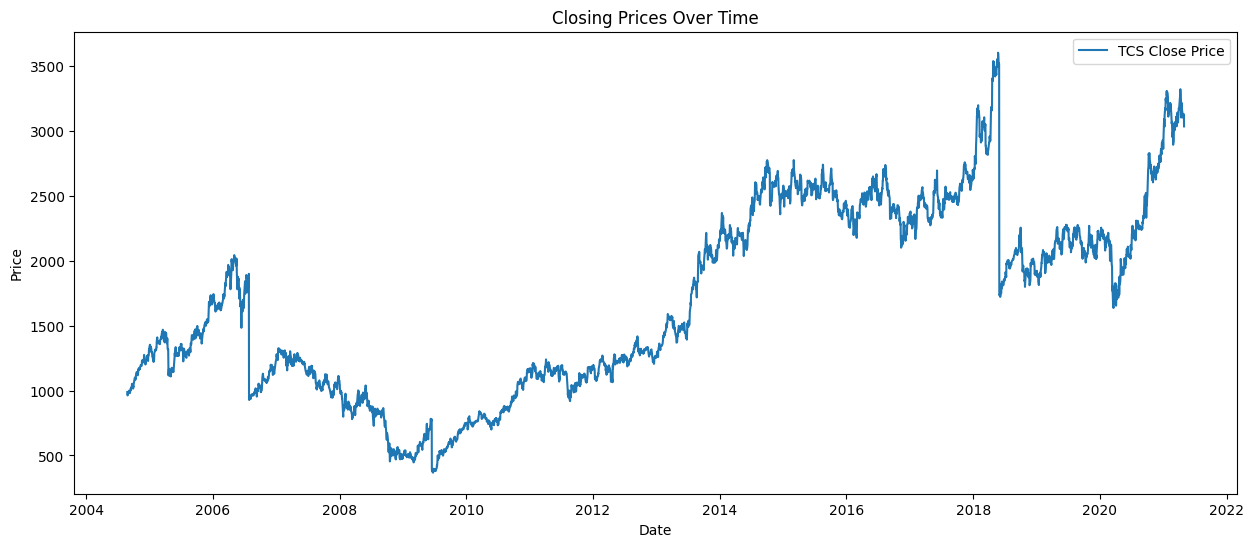

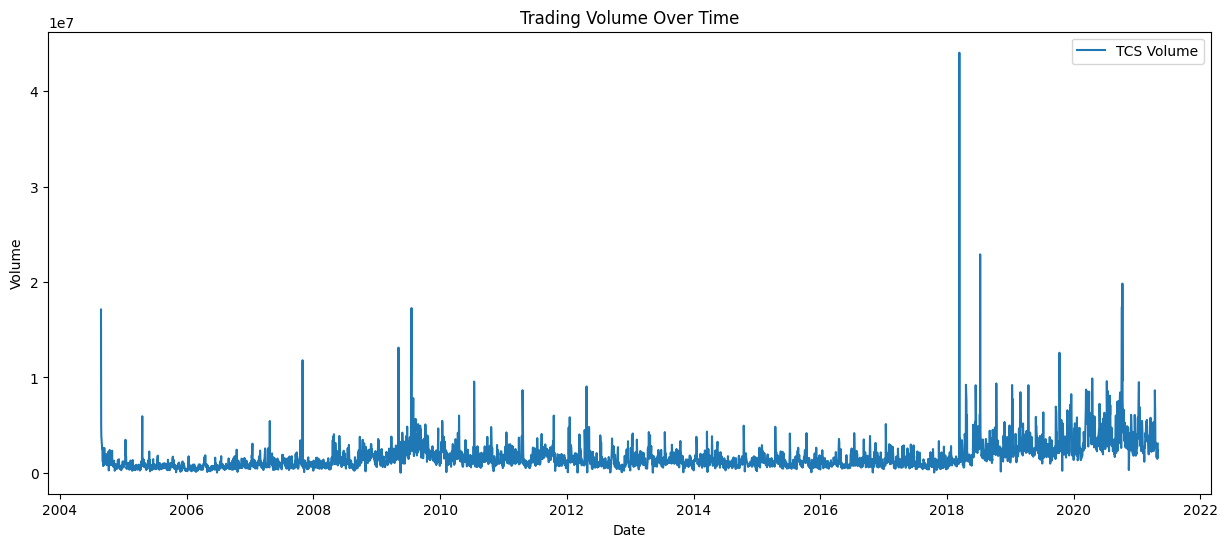

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
for stock in stocks:
    plt.plot(data[stock]['Date'], data[stock]['Close'], label=f'{stock} Close Price')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for stock in stocks:
    plt.plot(data[stock]['Date'], data[stock]['Volume'], label=f'{stock} Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

###**Moving Averages and Plot for TCS**

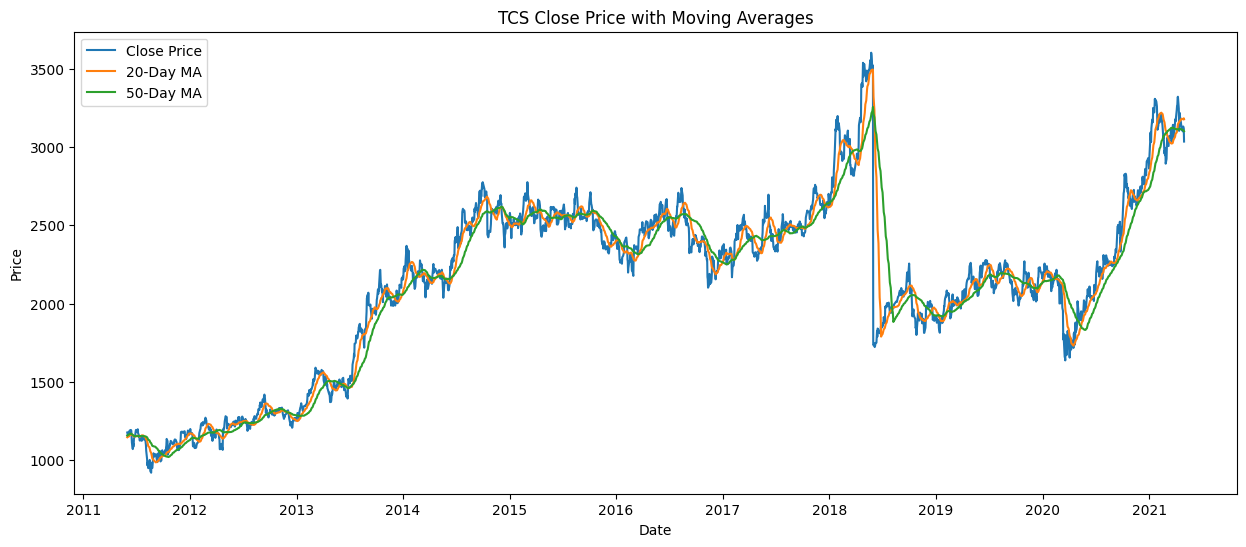

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(tcs_data['Date'], tcs_data['Close'], label='Close Price')
plt.plot(tcs_data['Date'], tcs_data['MA20'], label='20-Day MA')
plt.plot(tcs_data['Date'], tcs_data['MA50'], label='50-Day MA')
plt.title('TCS Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

###**Prepare Data for LSTM Model**

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_lstm_data(stock_df, time_step=60):
    close_prices = stock_df['Close'].values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_prices)

    X, Y = [], []
    for i in range(len(scaled_data)-time_step-1):
        X.append(scaled_data[i:i+time_step, 0])
        Y.append(scaled_data[i + time_step, 0])

    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, Y, scaler

# Test function on TCS
X_tcs, Y_tcs, scaler_tcs = prepare_lstm_data(data['TCS'])
print(f"TCS LSTM data shapes: X={X_tcs.shape}, Y={Y_tcs.shape}")

TCS LSTM data shapes: X=(4078, 60, 1), Y=(4078,)


###**Build and Train LSTM Model**

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def build_train_lstm(X_train, Y_train, epochs=7):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, epochs=epochs, batch_size=32, verbose=1)
    return model

# Prepare train/test split for TCS
train_size = int(len(X_tcs)*0.8)
X_train_tcs, X_test_tcs = X_tcs[:train_size], X_tcs[train_size:]
Y_train_tcs, Y_test_tcs = Y_tcs[:train_size], Y_tcs[train_size:]

print("Training LSTM model for TCS")
model_tcs = build_train_lstm(X_train_tcs, Y_train_tcs)

Training LSTM model for TCS


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0228
Epoch 2/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0017
Epoch 3/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0014
Epoch 4/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0013
Epoch 5/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 9.8022e-04
Epoch 6/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 9.7617e-04
Epoch 7/7
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 9.8061e-04


###**Predict and Plot Actual vs Predicted for TCS**

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


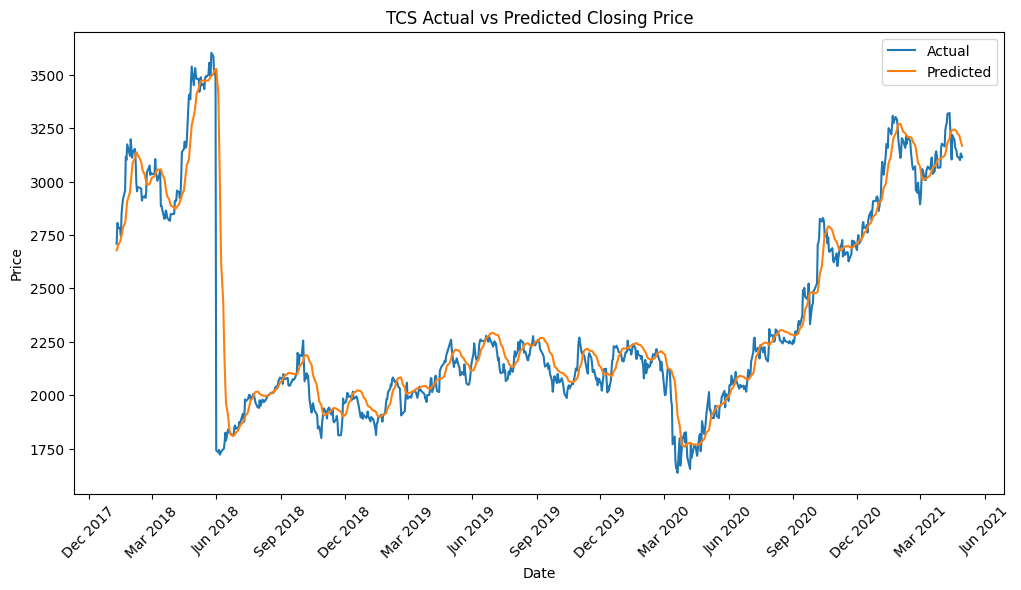

In [48]:
# Predict on test data
predictions_tcs = model_tcs.predict(X_test_tcs)
predictions_tcs = scaler_tcs.inverse_transform(predictions_tcs)
Y_test_tcs_actual = scaler_tcs.inverse_transform(Y_test_tcs.reshape(-1,1))

import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(data['TCS']['Date'][-len(Y_test_tcs_actual):], Y_test_tcs_actual, label='Actual')
plt.plot(data['TCS']['Date'][-len(predictions_tcs):], predictions_tcs, label='Predicted')
plt.title('TCS Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

###**Correlation Heatmap of TCS Features**

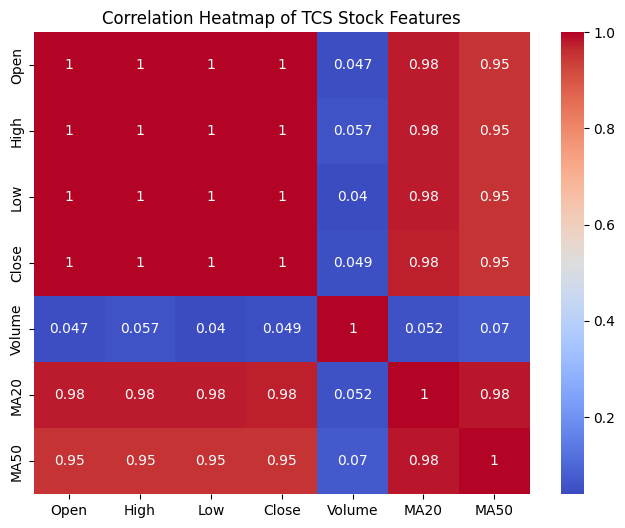

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
cols_to_corr = ['Open','High','Low','Close','Volume','MA20','MA50']

sns.heatmap(tcs_data[cols_to_corr].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of TCS Stock Features')
plt.show()

###**Candlestick Chart Using Plotly**

In [55]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=tcs_data['Date'],
    open=tcs_data['Open'],
    high=tcs_data['High'],
    low=tcs_data['Low'],
    close=tcs_data['Close'],
    name='TCS'
)])

fig.update_layout(title='TCS Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()